# Astra target landing site example

## Derivation of Nozzle lift equation (fixed ascent rate)

An estimate of the bounds of Nozzle lift is required for scipy's differential evolution algorithm. We'll use a primitive approach, since the method calculates (integrates) the ascent rate equation anyway, and a penalty method will be used for ascent rates reaching outside the desired boundaries.

Force balance:

\begin{equation}
(m_{bal} + m_{pay} + m_{gas}) \frac{d^2z}{dt^2} = B - W - D = 0\\
B = W + D\\
V(\rho_{air} - \rho_{gas}) g = (m_{bal} + m_{pay})g + \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D A
\end{equation}

Then use balloon volume to get a 3rd order polynomial in terms of $r$

\begin{equation}
\frac{4}{3} \pi (\rho_{air} - \rho_{gas}) g r^3 - \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D \pi r^2 - (m_{bal} + m_{pay})g = 0
\end{equation}

Solve for r, and extract real positive root. This root should be unique, since the cubic discriminant $18abcd - 14b^3d + b^2c^2 - 4ac^3 - 27a^2d^2$ is always less than zero for $a>0, b<0, c=0, d<0$, leading to one real and two complex conjugate roots. Then use the relation of gas mass (eqn 3 in "High-Altitude Gas Balloon Trajectory Prediction: A Monte Carlo Model") to obtain the nozzle lift:

\begin{equation}
m_{gas} = \rho^0_{gas} V^0 = \rho^0_{gas} \frac{L_N/g + m_{bal}}{\rho^0_{air} - \rho^0_{gas}}\\
L_N/g = \frac{4\pi}{3} r^3 (\rho_{air}-\rho_{gas}) - m_{bal} \hspace{1em} (kg)
\end{equation}

This is found in ```astra.flight_tools.nozzleLiftFixedAscent```, and has been validated with [habhub](http://habhub.org/calc/), which gives nozzle lift values of the same magnitude, and similar value (+- 10%)

**Note** After finding the section of habhub burst calculator that does this, it was apparent that $r$ and $m_{gas}$ is solved in the same way. See function `calc_update()` https://github.com/cuspaceflight/cusf-burst-calc/blob/master/js/calc.js

## Ground distance equation

The Haversine formula is used to obtain ground distance $\Delta$ of the landing site from its target (assuming a spherical Earth), as

\begin{equation}
    \Delta = 2r\dot{}\mathrm{arcsin}\left( \sqrt{\mathrm{sin^2} \left( \frac{\phi_2 - \phi_1}{2}\right) + \mathrm{cos}(\phi_1) \mathrm{cos}(\phi_2) \mathrm{sin}^2 \left(\frac{\lambda_2 - \lambda_1}{2}\right)  }\right),
\end{equation}

where $\phi, \lambda$ refer to latitude and longitude respectively, and $r$ is the Earth's average radius ($=6371km$)

## 2D Optimization: Time + Nozzle Lift

In [1]:
%load_ext autoreload
%autoreload
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
import astra
import os
from astra.GFS import GFS_Handler
%matplotlib notebook

In [2]:
targetLat = 51.077214
targetLon = -1.1866875398775423
targetElev = 137

# Set the optimisation weights used for [distance from target, cost, flight duration] respectively:
# Note that these are negative, because we'd like to a minimize both.
weights = (-1, -0.1, -0.)

# Use a previous forecast (allows offline development)
launch_datetime = datetime.now() + timedelta(days=1)
inputs = {}
# simEnvironment = forecastEnvironment(launchSiteLat=50.903824,      # deg
#                                      launchSiteLon=-1.63697,     # deg
#                                      launchSiteElev=114.0,           # m
#                                      dateAndTime=launch_datetime,
#                                      forceNonHD=True,
#                                      debugging=True,
#                                      requestSimultaneous=False  # False has better memory overhead
#                                     )
# # Set up the example input data files (from 22/06/2017, Daytona Beach)
# fileDict = {}
# for paramName in GFS_Handler.weatherParameters.keys():
#     fileDict[paramName] = os.path.abspath('./data/gfs_0p50_06z.ascii?{}[11:36][0:46][263:301][0:719]'.format(paramName))
# simEnvironment.loadFromNOAAFiles(fileDict)
# inputs['lanuchSiteForecasts'] = simEnvironment

simulator = targetFlight(start_dateTime=launch_datetime,
                 targetLat=targetLat,
                 targetLon=targetLon,
                 targetElev=targetElev,
                 launchSites=[(50.903824, -1.63697, 114.0)],
                 balloonModel='TA800',
                 balloonGasType="Helium",
                 nozzleLift=1,
                 trainEquivSphereDiam=0.1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=72,
                 weights=weights,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 debugging=True,
                 log_to_file=False,
                 progress_to_file=False,
                 outputFile=os.path.join(''),
                 **inputs)

Check Weather Interpolators work over this range (i.e., ensure they are not constant/extrapolations)

In [3]:
import copy
%autoreload
import astra

# Number of x-y points to use
Nx = 21
Ny = 21

simulator.balloonModel = 'TA100'
simulator.weights = (-1, -0.1, -0.)

# This will download the forecast, if it hasn't been loaded already
bestProfile_bf, X, Y,scores = simulator.bruteForce(Nx, Ny)
results_bf = copy.deepcopy(simulator.results)

DEBUG:astra.weather:Fetched time zone data about the launch site: UTC offset is 1.000000 hours
DEBUG:astra.weather:Using UTC time 23/06/17 14:00
INFO:astra.weather:Preparing to download weather data for parameters:
DEBUG:astra.weather:    Launch site Latitude: 50.903824
DEBUG:astra.weather:    Launch site Longitude: -1.63697
DEBUG:astra.weather:    Launch time: 2017-06-23 14:00:00
DEBUG:astra.GFS:Attempting to download cycle data.
DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170623/gfs_0p50_12z.ascii?tmpprs[0:1][0:46][263:301][0:719]


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170623/gfs_0p50_12z.ascii?tmpprs[0:25][0:46][263:301][0:719]
DEBUG:astra.GFS:Temperature data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170623/gfs_0p50_12z.ascii?hgtprs[0:25][0:46][263:301][0:719]
DEBUG:astra.GFS:Altitude data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170623/gfs_0p50_12z.ascii?ugrdprs[0:25][0:46][263:301][0:719]
DEBUG:astra.GFS:U Winds data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170623/gfs_0p50_12z.ascii?vgrdprs[0:25][0:46][263:301][0:719]
DEBUG:astra.GFS:V Winds data downloaded


Weather downloaded.


DEBUG:astra.GFS:Forecast successfully downloaded!
DEBUG:astra.weather:GFS data successfully downloaded.
INFO:astra.target_landing:Date range: [2017-06-23 15:00:00, 2017-06-26 15:00:00], Nx=21 points
INFO:astra.target_landing:Nozzle Lift range: [0.41604821396915026, 1.7128711861717523] (kg), Ny=21 points
DEBUG:astra.target_landing:Running brute force calculation
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 15:00:00, nozzleLift=0.41604821396915026kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 15:00:00, nozzleLift=0.42843353411847884kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 15:00:00, nozzleLift=0.4430266724097305kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 15:00:00, nozzleLift=0.460039698877879kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 15:00:00, nozzleLift=0.4797269468071236kg, balloon TA100
DEBUG:astra.target_l

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.42843353411847884kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.4430266724097305kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.460039698877879kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.4797269468071236kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.5023918138173065kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.5283949920115254kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.5581643751083459kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:48:00, nozzleLift=0.5922069261776853kg, balloon TA100
DEBUG:astra.targ

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.5023918138173065kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.5283949920115254kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.5581643751083459kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.5922069261776853kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.63112282287822kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.6756222237653905kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.7265450133779605kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 12:36:00, nozzleLift=0.7848838776544597kg, balloon TA100
DEBUG:astra.target

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.63112282287822kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.6756222237653905kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.7265450133779605kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.7848838776544597kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.8518110254643895kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.9287087967478161kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=1.0172042743262426kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=1.1192078405820318kg, balloon TA100
DEBUG:astra.target

DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=0.8518110254643895kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=0.9287087967478161kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=1.0172042743262426kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=1.1192078405820318kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=1.2369553958750616kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=1.373053699084216kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=1.5305280332662028kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 10:12:00, nozzleLift=1.7128711861717523kg, balloon TA100
DEBUG:astra.targe

DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 21:00:00, nozzleLift=1.2369553958750616kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 21:00:00, nozzleLift=1.373053699084216kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 21:00:00, nozzleLift=1.5305280332662028kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 21:00:00, nozzleLift=1.7128711861717523kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 00:36:00, nozzleLift=0.41604821396915026kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 00:36:00, nozzleLift=0.42843353411847884kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 00:36:00, nozzleLift=0.4430266724097305kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 00:36:00, nozzleLift=0.460039698877879kg, balloon TA100
DEBUG:astra.targ

DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.41604821396915026kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.42843353411847884kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.4430266724097305kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.460039698877879kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.4797269468071236kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.5023918138173065kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.5283949920115254kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 11:24:00, nozzleLift=0.5581643751083459kg, balloon TA100
DEBUG:astra.tar

<IPython.core.display.Javascript object>


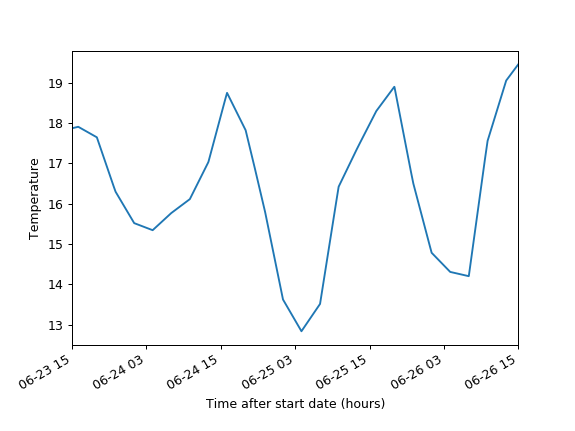

In [21]:
# Temperature visualation at the landing site, over the time window
import matplotlib.dates as mdates

simEnvironment = simulator.environment

# Plot weather as a function of time over the date range:
ts = np.linspace(0, simulator.windowDuration, 3001)
datetimes = [simEnvironment.dateAndTime + timedelta(hours=t) for t in ts]

Ps = [simEnvironment.getTemperature(simEnvironment.launchSiteLat,
                                        simEnvironment.launchSiteLon,
                                        simEnvironment.launchSiteElev, dt)
          for dt in datetimes]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(datetimes, Ps)
ax.set_ylabel("Temperature")
ax.set_xlabel("Time after start date (hours)")

xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.set_xlim(datetimes[0], datetimes[-1])

fig.autofmt_xdate()

<IPython.core.display.Javascript object>


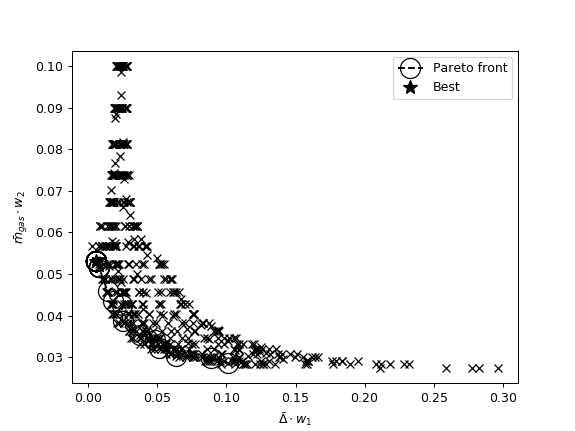

In [22]:
# simulator.results contains the lexographically sorted pareto front of the
# non dominated flights (based on weighted distance vs cost)
import matplotlib.tri as mtri


def plotParetoFront(fitnesses, paretoFront):
    """Plots the points stored in the simulator.ParetoFront (containing the non-dominated
    Pareto efficient individuals).
    
    Notes
    -----
    * Only works for 2 or 3 objectives. 
    * Assumes that all fitnesses have the same number of values and weightings
    """
    nonzero_indices = np.nonzero(fitnesses[0].weights)[0]
    assert(len(nonzero_indices) >= 2),\
        "Input fitness array has less than 2 weighted objectives: no useful Pareto solutions."
        
    # Dictionary of weight_index : label pairs. Extract the axes labels for the non zero weighted vars
    axlabelsAvailable = {0: r'$\bar{\Delta} \cdot w_1$',
                       1: r'$\bar{m}_{gas} \cdot w_2$',
                       2: r'$\bar{t} \cdot w_3$'}
    axlabels = [axlabelsAvailable[idx] for idx in nonzero_indices]
    
    if len(nonzero_indices) == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fs = list(zip(*[fitness.wvalues for fitness in fitnesses]))
        f1 = -np.array(fs[nonzero_indices[0]])
        f2 = -np.array(fs[nonzero_indices[1]])
        ax.plot(f1, f2, 'kx')
        pareto_vars = list(zip(*[profile.fitness.wvalues for profile in paretoFront]))
        pareto_array = -np.array([pareto_vars[nonzero_indices[0]], pareto_vars[nonzero_indices[1]]]).T
        pareto_array = pareto_array[np.argsort(pareto_array[:, 1])]
        ax.plot(pareto_array[:, 0], pareto_array[:, 1], 'ko--', mfc='none',
                markersize=16, label='Pareto front')

        # Find best (assumes that the weights are tuned to how import each parameter is)
        iBest = np.argmin(pareto_array[:,0] + pareto_array[:, 1])
        ax.plot(pareto_array[iBest, 0], pareto_array[iBest, 1], 'k*', markersize=12, label='Best')

        # Formatting
        ax.set_xlabel(axlabels[0])
        ax.set_ylabel(axlabels[1])
        ax.legend(loc='upper right')
        
    elif len(nonzero_indices) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        f1, f2, f3 = zip(*[fitness.wvalues for fitness in fitnesses])
        f1 = -np.array(f1)
        f2 = -np.array(f2)
        f3 = -np.array(f3)
        ax.scatter(f1, f2, f3, label='Brute Force Points')
        pareto_x, pareto_y, pareto_z = zip(*[profile.fitness.wvalues for profile in paretoFront])
        pareto_array = -np.array([pareto_x, pareto_y, pareto_z]).T
    
        ax.scatter(pareto_array[:, 0], pareto_array[:, 1], pareto_array[:, 2])#, facecolors='k',
#                    label='Pareto points')
    
        # Plot the Pareto surface triangulation
        triang = mtri.Triangulation(pareto_array[:,0],pareto_array[:,1])
        ax.plot_trisurf(triang,pareto_array[:,2],color='red', alpha=0.5)

        # Find best (assumes that the weights are tuned to how important each parameter is)
        iBest = np.argmin(pareto_array[:,0] + pareto_array[:, 1])
        ax.plot([pareto_array[iBest, 0]], [pareto_array[iBest, 1]], [pareto_array[iBest, 2]], 'k*', markersize=12, label='Best')

        # Formatting
        ax.set_xlabel(axlabels[0])
        ax.set_ylabel(axlabels[1])
        ax.set_zlabel(axlabels[2])
        ax.legend(loc='upper right')        
    
    else:
        raise ValueError("Can't support plotting {}D Pareto front. Adjust weightings.".format(len(nonzero_indices)))
    
        return None

plotParetoFront(simulator.fitnesses, simulator.results)

<IPython.core.display.Javascript object>


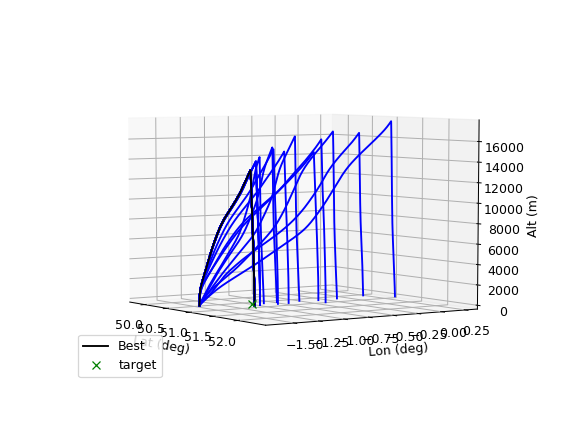

(<matplotlib.figure.Figure at 0x7f2f00daa828>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f2f00dbc048>)

In [23]:
# Visualise the Pareto Front result paths (This may not be all that useful)
simulator.plotPaths3D()

<IPython.core.display.Javascript object>


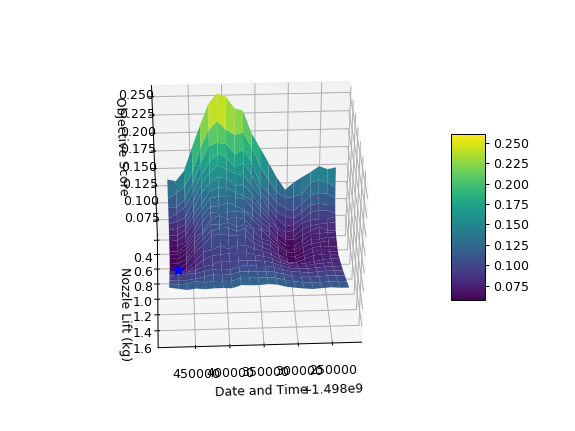

In [24]:
# Visualise the surface as a 3D surface contour:
%autoreload
from matplotlib import cm

fig1, ax1 = simulator.plotObjectiveContours3D(
    X, Y, scores.T, appendLabel=' Brute Force', cmap=cm.viridis, bestProfile=bestProfile_bf)

In [8]:
%autoreload
import astra

# fig3, ax3 = simulator.plotObjectiveContours(X, Y, scores.T,
#     appendLabel=' Brute Force', bestProfile=bestProfile_bf)

# To manually set the levels used in the plot, pass the levels as an additional arg:
levels = np.linspace(0.0, 0.16, 9)
print(levels)
fig3, ax3 = simulator.plotObjectiveContours(X, Y, scores.T,
    appendLabel=' Brute Force', bestProfile=bestProfile_bf, levels=levels)

[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16]


<IPython.core.display.Javascript object>

## Nelder Mead Simplex Algorithm

Running the code here will update the contour plot above.

In [9]:
%autoreload
import astra

In [10]:
# Optimize with Scipy:

res_scipy = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0],
                                                options={'xtol': 1e-6, "disp": True, 'maxiter':50})
bestProfile_scipy = simulator.bestProfile
results_scipy = simulator.results
Xs_scipy = simulator.Xs

DEBUG:astra.target_landing:Arguments in the objective function are: ['t', 'targetAscentRate']
/home/pchambers/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 03:00:00, nozzleLift=0.39559525477833835kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 04:48:00, nozzleLift=0.39559525477833835kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 03:00:00, nozzleLift=0.39723159412518105kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 01:12:00, nozzleLift=0.3972315941251797kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.39808251527862515kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.383078236791615kg, b

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.395508, nozzleLift=0.3822376679534878kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.395508, nozzleLift=0.3822376500336756kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.38223744073678767kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.296631, nozzleLift=0.38223759770853005kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.197754, nozzleLift=0.38223754538399557kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.197754, nozzleLift=0.38223753642432823kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.38223743177732994kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.148315, nozzleLift=0.382

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.000006, nozzleLift=0.38223742282163653kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.000006, nozzleLift=0.382237422821358kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.3822374228181632kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.000005, nozzleLift=0.38223742282056083kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.000003, nozzleLift=0.3822374228197618kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.000003, nozzleLift=0.3822374228196248kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.3822374228180263kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00.000002, nozzleLift=0.3822374

DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.38223742281788975kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.3822374228178901kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.38223742281789086kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 23:24:00, nozzleLift=0.38223742281789086kg, balloon TA100


In [11]:
# Optimize with scipy differential evolution
simulator.Xs = Xs_scipy
simulator.plotObjectiveLocations(fig3, ax3, marker='rx', bestMarker='r*', 
                                   bestProfile=bestProfile_scipy, appendLabel=' Nelder-Mead')

(<matplotlib.figure.Figure at 0x7f2f01881e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f01f2cdd8>)

In [12]:
print(res_scipy)

 final_simplex: (array([[ 32.4       ,   0.38223742],
       [ 32.4       ,   0.38223742],
       [ 32.4       ,   0.38223742]]), array([  2.38664012e-01,   5.00000000e+06,   5.00000000e+06]))
           fun: 0.23866401244634411
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 197
           nit: 50
        status: 2
       success: False
             x: array([ 32.4       ,   0.38223742])


## L-BFGS-B Algorithm

Commenting out the code here for now, as the optimization doesn't work so well...

In [13]:
# from astra.flight_tools import nozzleLiftFixedAscent

# # Optimize with Scipy:
# start_timedelta = 0
# end_timedelta = simulator.windowDuration

# nozzleLiftLowerBound = nozzleLiftFixedAscent(simulator.minAscentRate,
#                 simulator._balloonWeight, simulator.payloadTrainWeight,
#                 simulator.environment.inflationTemperature,
#                 simulator.environment.getPressure(simulator.launchSiteLat,
#                                                   simulator.launchSiteLon,
#                                                   simulator.launchSiteElev,
#                                                   simulator.start_dateTime),
#                 simulator._gasMolecularMass, simulator.excessPressureCoeff,
#                 CD=(0.225 + 0.425)/2.)
# nozzleLiftUpperBound = nozzleLiftFixedAscent(simulator.maxAscentRate,
#                 simulator._balloonWeight, simulator.payloadTrainWeight,
#                 simulator.environment.inflationTemperature,
#                 simulator.environment.getPressure(simulator.launchSiteLat,
#                                                   simulator.launchSiteLon,
#                                                   simulator.launchSiteElev,
#                                                   simulator.start_dateTime),
#                 simulator._gasMolecularMass, simulator.excessPressureCoeff,
#                 CD=(0.225 + 0.425)/2.)

# res_lbfgsb = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0],
#                                                  method='L-BFGS-B',
#                                                  bounds=([start_timedelta, end_timedelta],
#                                                          [nozzleLiftLowerBound, nozzleLiftUpperBound]),
#                                                  options={"disp": True, "maxfun":200},
#                                                  )
# bestProfile_lbfgsb = simulator.bestProfile
# results_lbfgsb = simulator.results
# Xs_lbfgsb = simulator.Xs

In [14]:
# # Optimize with scipy differential evolution
# simulator.bestProfile = bestProfile_lbfgsb
# simulator.results = results_lbfgsb
# simulator.Xs = Xs_lbfgsb
# simulator.plotObjectiveLocations(fig3, ax3, marker='cx', bestMarker='c*', appendLabel=' L-BFGS-B')

In [15]:
# print(res_lbfgsb)

## Scipy differential Evolution

In [16]:
%autoreload
import astra

res_de = simulator.optimizeTargetLandingSite(method='DE', tol=1, maxiter=6)
results_de = simulator.results
bestProfile_de = simulator.bestProfile
Xs_de = simulator.Xs

DEBUG:astra.target_landing:Arguments in the objective function are: ['t', 'targetAscentRate']
DEBUG:astra.target_landing:Running flight for datetime 2017-06-23 17:00:50.629120, nozzleLift=1.24450884403502kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 11:37:22.107400, nozzleLift=0.9587357491709797kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 17:06:56.754301, nozzleLift=1.3215369798248668kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 08:20:19.413238, nozzleLift=0.7314762905477008kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 01:24:03.608847, nozzleLift=1.4866449110005764kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-25 22:43:18.231916, nozzleLift=0.4627785436314583kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-24 05:22:07.810272, nozzleLift=0.6721082706677209kg, balloon TA10

DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600011, nozzleLift=0.9283096509162986kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600047, nozzleLift=0.9283096509162986kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600011, nozzleLift=0.9283096545761703kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600011, nozzleLift=0.8625322322733114kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600047, nozzleLift=0.8625322322733114kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600011, nozzleLift=0.8625322355245414kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600011, nozzleLift=0.8622055830136821kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-06-26 13:09:49.600047, nozzleL

In [17]:
res_de

     fun: 0.058484812190195246
     jac: array([ 0.        ,  0.04079902])
 message: 'Optimization terminated successfully.'
    nfev: 120
     nit: 1
 success: True
       x: array([ 70.16377778,   4.45731133])

In [18]:
simulator.results = results_de
simulator.bestProfile = bestProfile_de
simulator.Xs = Xs_de
simulator.plotObjectiveLocations(fig3, ax3, marker='kx', bestMarker='k*', appendLabel=' DE')

(<matplotlib.figure.Figure at 0x7f2f01881e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f01f2cdd8>)

In [19]:
fig3.savefig('Distance2D_NozzleLift_LaunchTime.pdf')

In [20]:
print("Brute Force: delta={} km, nevals={}".format(bestProfile_bf.distanceFromTarget, Nx * Ny))
print("Differential Evolution: delta={} km, nevals={}".format(bestProfile_de.distanceFromTarget, res_de.nfev))
print("Nelder Mead: delta={} km, nevals={}".format(bestProfile_scipy.distanceFromTarget, res_scipy.nfev))

AttributeError: 'targetProfile' object has no attribute 'distanceFromTarget'

## Higher Dimensional Problem

### Slice with cutdown altitude

In [ ]:
import copy
%autoreload
import astra

# Number of x-y points to use
Nx = 6
Ny = 6

# Could also use 'floatingAltitude' as the sliceParam
bestProfile_slicing, X, Y, Z, distances = simulator.bruteForceSlice(Nx, Ny, sliceParam='cutdownAltitude',
                                                            Nslices=3, sliceBounds=(10e3, 18e3))
results_slicing = copy.deepcopy(simulator.results)



In [ ]:
for i, z in enumerate(Z):
    scores_slice = distances[:, :, i]
# #     levels = np.arange(0, 90, 10)
    fig, ax = simulator.plotObjectiveContours(X, Y, scores_slice.T,
        appendLabel=' Brute Force')
    ax.set_title(r"Cutdown Altitude: ${}m$".format(z))
#     fig.savefig('cutdownAltitude_{}_contour.pdf'.format(z))

## Optimization in higher dimensions

The input vector we will try to solve the following optimization problem

\begin{equation}
\mathrm{min}(f(\textbf{x})) \\
f(\mathbf{x}) = \mathrm{\Delta}(\textbf{x}) + p_0(\textbf{x})\\
p_0 = \begin{cases} 
    5 \times 10^6 & \text{if not landed} \\
    & 0 & \text{otherwise}
   \end{cases}\\
\textbf{x} = [t, L_N, i_f, h_f, t_f, i_c, h_c, D_\mathrm{burst}],\\
t \in [0, 72] \mathrm{hours}\\
L_N \propto \bar{\frac{dz}{dt}}, \hspace{1em} \bar{\frac{dz}{dt}} \in [1.5, 6] \mathrm{m/s}\\
i_f \in [0, 1] \\
h_f \in [h_{f0}, h_{f1}]\\
t_f \in [0, \infty]\\
i_c \in [0, 1]\\
h_c \in [h_{c0}, h_{c1}]\\
D_\mathrm{burst} \in [D_\mathrm{burst0}, D_\mathrm{burst1}]
\end{equation}

where \Delta is the ground distance from the landing site obtained for a particular input vector $\bf{x}$, subscripts $f$ and $c$ denote floating and cutdown flight, $i_f, i_c$ are real variables bounded $\in [0, 1]$ that correspond to binary *on/off* behaviour, $h$ denotes altitude, $D_{burst}$ is the nominal burst diameter (continuous) varying between the bounds of a subset of chosen 'available' balloons, and $t_f$ is the duration  force the balloon to drop after a floating flight . Currently $h_{f0}, h_{f1}, h_{c0}, h_{c1}$ are user inputs for 'sensible' values of floating or cutdown flight altitude for a given mission, taking into account the nominal balloon burst altitude, local regulations and air traffic; however, this may be eligible for calculation in future.

Differential evolution was the most robust in the previous example, independant of the initial (conversely to Nelder-Mead), so we'll use it here.

**Notes**
* `cutdown` does not have to be activated ($i_c = 1$) for floating flight to begin decent after flight duration $t_c$.

In [ ]:
%autoreload
import astra

res_de_HD = simulator.optimizeTargetLandingSite(method='DE', useCutdown=True, useFloating=True,
                                             cutdownAltitudeBounds=(8e3, 16e3), floatingAltitudeBounds=(8e3, 16e3),
                                             flexibleBalloon=True,
                                             balloonModels=['TA100', 'TA200', 'HW200', 'HW800'],
                                             tol=1, maxiter=5, seed=62)
results_de_HD = simulator.results
bestProfile_de_HD = results_de_HD[0]
Xs_de_HD = simulator.Xs


In [ ]:
plotParetoFront(simulator.fitnesses, simulator.results)

In [ ]:
print(len(simulator.results))

In [ ]:
res_de_HD

In [ ]:
simulator.plotPaths3D()

## Testing

Random elements of code to go here....

In [ ]:
# This url appears to have problems in some circumstances - is it a cycle not available error, or something else?
url = "http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170619/gfs_0p50_06z.ascii?hgtprs[10:35][0:46][263:301][0:719]"

from six.moves.urllib.request import urlopen

for i in range(20):
    HTTPresponse = urlopen(url)
    response = HTTPresponse.read().decode('utf-8')
    if response[0] == "<":
        print(response)

In [ ]:
import datetime
td = datetime.timedelta(seconds=666)
td.seconds

In [ ]:
balloonModels = 'TA100', 'HW1000', 'TA2000'
balloonsSelected = {k: balloons[k] for k in balloonModels}
balloonsSelected

In [ ]:
max(balloonsSelected, key=lambda k: balloonsSelected.get(k)[1])